# Convolutional Neural Network Model for Land Classification

## ResNet50 Sequential

### Importing Necessary Libraries

In [8]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # For reading image files

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, MaxPooling2D, Dropout

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix  # For computing confusion matrix
from scipy import misc, ndimage  # For image processing

# Import for plotting model architecture
from tensorflow.keras.utils import plot_model  # For creating a visual representation of the model

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [61]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)

In [62]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
dataset_path = 'C:/Users/isaac/datasets'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

In [63]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [64]:
# Iterate through each category within the categories list 
for category in categories:
    # Construct the path to the training images directory for the current category
    tr = os.path.join(train_path, category)
    # Get the number of training images in the current category
    len_tr = len(os.listdir(tr))

    # Construct the path to the validation images directory for the current category
    val = os.path.join(valid_path, category)
    # Get the number of validation images in the current category
    len_val = len(os.listdir(val))

    # Construct the path to the test images directory for the current category
    test = os.path.join(test_path, category)
    # Get the number of test images in the current category
    len_test = len(os.listdir(test))

    # Printing the category names and the training, validation and test images for each category
    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

In [13]:
# Create a data generator for the training dataset
# This generator will load and preprocess images from the 'train_path' directory
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(224, 224),
    classes=categories,
    batch_size=32
)
# Create a data generator for the validation dataset
# This generator will load and preprocess images from the 'valid_path' directory
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(224, 224),
    classes=categories,
    batch_size=16
)
# Create a data generator for the test dataset
# This generator will load and preprocess images from the 'test_path' directory
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(224, 224),
    classes=categories,
    batch_size=16,
    shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


In [14]:
# Import ResNet50 model from Keras applications module
resnet50_model = tensorflow.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))

# Display summary of the VGG16 model architecture
resnet50_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# Create a new Sequential model
model = Sequential()

# Add the ResNet50 model to the new model
model.add(resnet50_model)

In [16]:
# Define the number of layers to freeze to adapt to the new dataset
num_layers = 10

# Freeze the weights of all layers except the last NUM_TRAINABLE_LAYERS layers
for layer in model.layers[0].layers[:-num_layers]:
    layer.trainable = False

# Add additional layers for fine-tuning and classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

# Display summary of the updated model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [18]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
%%time
history = model.fit(
    train_batches,
    steps_per_epoch=1080,
    validation_data=valid_batches,
    validation_steps=270,
    epochs=10,
    verbose=2
)

Epoch 1/10
1080/1080 - 406s - 376ms/step - accuracy: 0.8500 - loss: 0.5051 - val_accuracy: 0.8881 - val_loss: 0.3495
Epoch 2/10
1080/1080 - 406s - 376ms/step - accuracy: 0.9756 - loss: 0.0708 - val_accuracy: 0.9156 - val_loss: 0.3397
Epoch 3/10
1080/1080 - 403s - 373ms/step - accuracy: 0.9919 - loss: 0.0247 - val_accuracy: 0.9044 - val_loss: 0.3809
Epoch 4/10
1080/1080 - 426s - 394ms/step - accuracy: 0.9972 - loss: 0.0126 - val_accuracy: 0.9222 - val_loss: 0.3744
Epoch 5/10
1080/1080 - 413s - 383ms/step - accuracy: 0.9908 - loss: 0.0277 - val_accuracy: 0.8963 - val_loss: 0.5275
Epoch 6/10
1080/1080 - 411s - 381ms/step - accuracy: 0.9819 - loss: 0.0641 - val_accuracy: 0.9126 - val_loss: 0.4625
Epoch 7/10
1080/1080 - 417s - 386ms/step - accuracy: 0.9831 - loss: 0.0508 - val_accuracy: 0.9074 - val_loss: 0.4893
Epoch 8/10
1080/1080 - 409s - 378ms/step - accuracy: 0.9919 - loss: 0.0279 - val_accuracy: 0.9148 - val_loss: 0.4834
Epoch 9/10
1080/1080 - 424s - 393ms/step - accuracy: 0.9920 - lo

In [20]:
# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes
# Print the class indices of the test images
print(test_labels)

print()

# Get the class-to-index mapping from the test_batches ImageDataGenerator
test_batches.class_indices

[0 0 0 ... 9 9 9]



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

Confusion matrix, without normalization
[[134   1   1   3   1   3   3   0   2   2]
 [  0 141   4   0   0   4   0   0   0   1]
 [  0   2 135   2   0   2   8   1   0   0]
 [  2   0   0 115   4   1   2   0   1   0]
 [  0   0   2   0 120   0   2   1   0   0]
 [  2   1   3   0   0  92   1   0   0   1]
 [  2   0  10   3   2   1 105   2   0   0]
 [  0   0   2   0   3   0   0 145   0   0]
 [  5   0   3   5   0   0   0   0 112   0]
 [  2   2   1   0   0   2   0   0   0 143]]


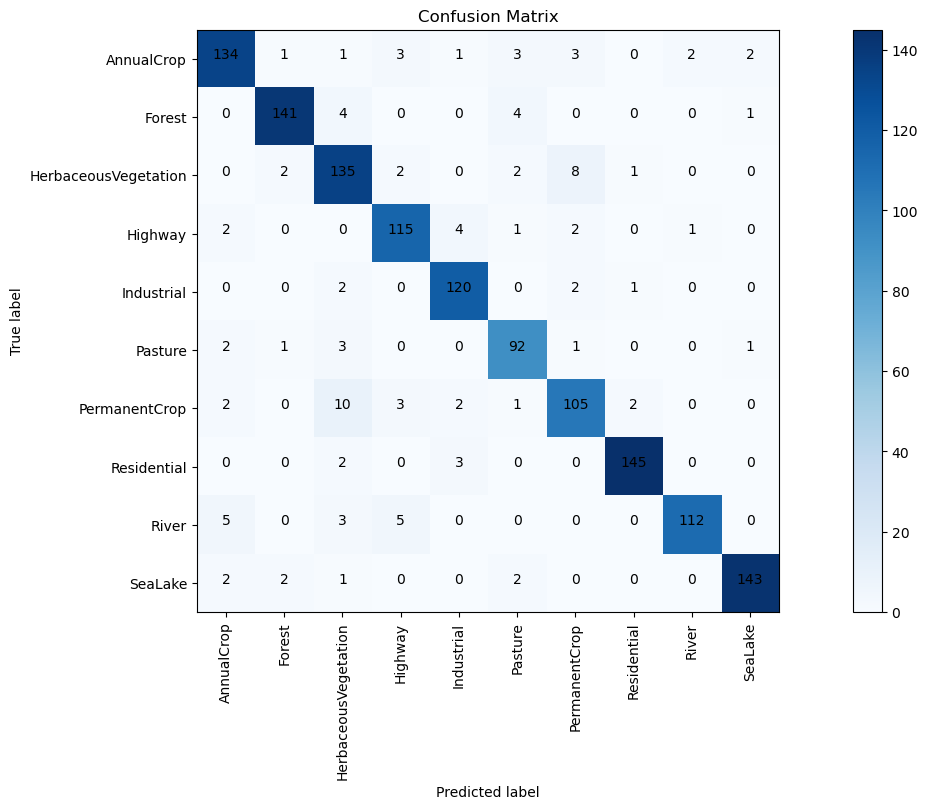

In [46]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

# Function to plot the confusion matrix - modified from scikit-learn.org
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, text_color='black', text_size=10, font_weight='normal'):                
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 8))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a colorbar to the plot
    
    # Set the tick marks and labels for the x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Rotate x-axis labels 90 degrees
    plt.yticks(tick_marks, classes)
            
    # Print whether the confusion matrix is normalized
    if normalize:
        print('Normalized confusion matrix')
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Set a threshold to determine text color based on the matrix value
    thresh = cm.max() / 2.
    
    # Iterate over the confusion matrix to add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i,j]:.2f}' if normalize else f'{cm[i,j]}',
                 horizontalalignment="center",
                 color=text_color if cm[i, j] > thresh else "black",
                 fontsize=text_size,
                 fontweight=font_weight)
    
    # Adjust the layout to fit the plot and add labels for the axes
    plt.tight_layout()
    plt.ylabel("True label")  # Label for the y-axis
    plt.xlabel("Predicted label")  # Label for the x-axis
# confusion matrix using the results of the model on the test set

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

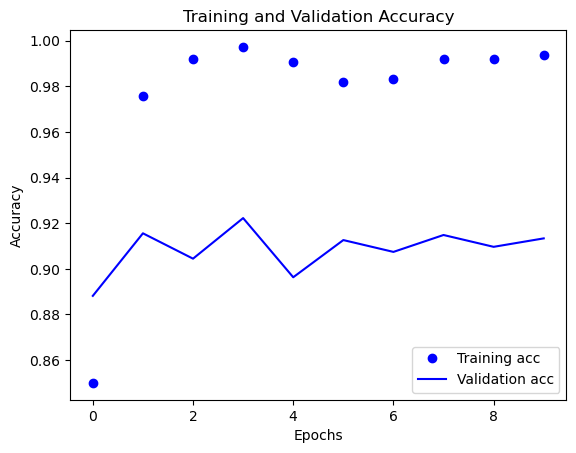

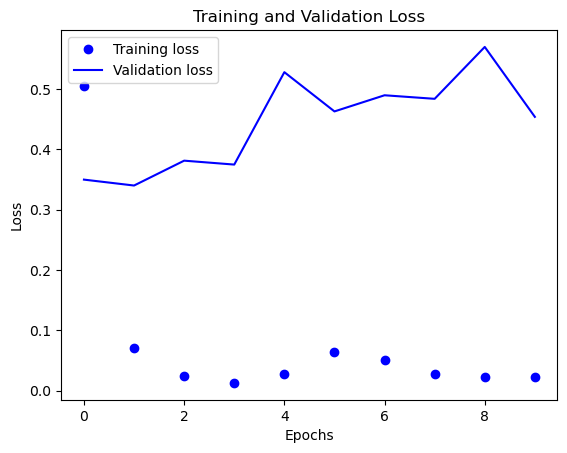

In [47]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Plot training and validation accuracy over epochs
plt.plot(epochs, acc, 'bo', label='Training acc')  # Plot training accuracy with blue dots
plt.plot(epochs, val_acc, 'b', label='Validation acc')  # Plot validation accuracy with a solid blue line
plt.title('Training and Validation Accuracy')  # Title of the accuracy plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation accuracy

# Create a new figure for the loss plot
plt.figure()

# Plot training and validation loss over epochs
plt.plot(epochs, loss, 'bo', label='Training loss')  # Plot training loss with blue dots
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot validation loss with a solid blue line
plt.title('Training and Validation Loss')  # Title of the loss plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation loss

# Display the plots
plt.show()  # Show the training and validation accuracy and loss plots

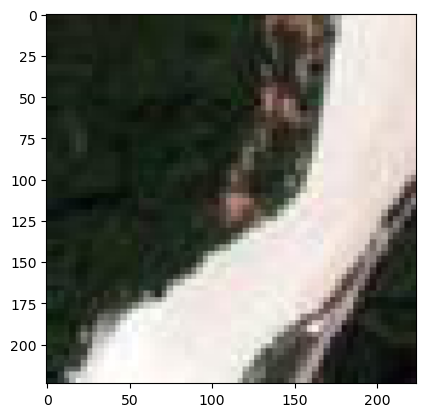

Image tensor shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Raw predictions: [[1.2223421e-08 3.4052289e-07 5.4844076e-09 6.3305367e-10 9.2288080e-11
  1.1944840e-09 4.2513191e-11 3.7549255e-11 1.9172048e-09 9.9999964e-01]]
Predicted class index is: 9


In [65]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    return img_tensor

# Path to the image
img_path = test_path + '/River/River_26.jpg'

# Preprocess the image
img_tensor = load_and_preprocess_image(img_path)

# Display the image
plt.imshow(img_tensor[0])
plt.show()

# Print the shape to ensure it's correct
print("Image tensor shape:", img_tensor.shape)

# Predict the class of the image
predictions = model.predict(img_tensor)

# Print the raw predictions
print("Raw predictions:", predictions)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)


Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\AnnualCrop\AnnualCrop_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Forest\Forest_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\HerbaceousVegetation\HerbaceousVegetation_1495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Highway\Highway_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Industrial\Industrial_1469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Pasture\Pasture_755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\PermanentCrop\Perman

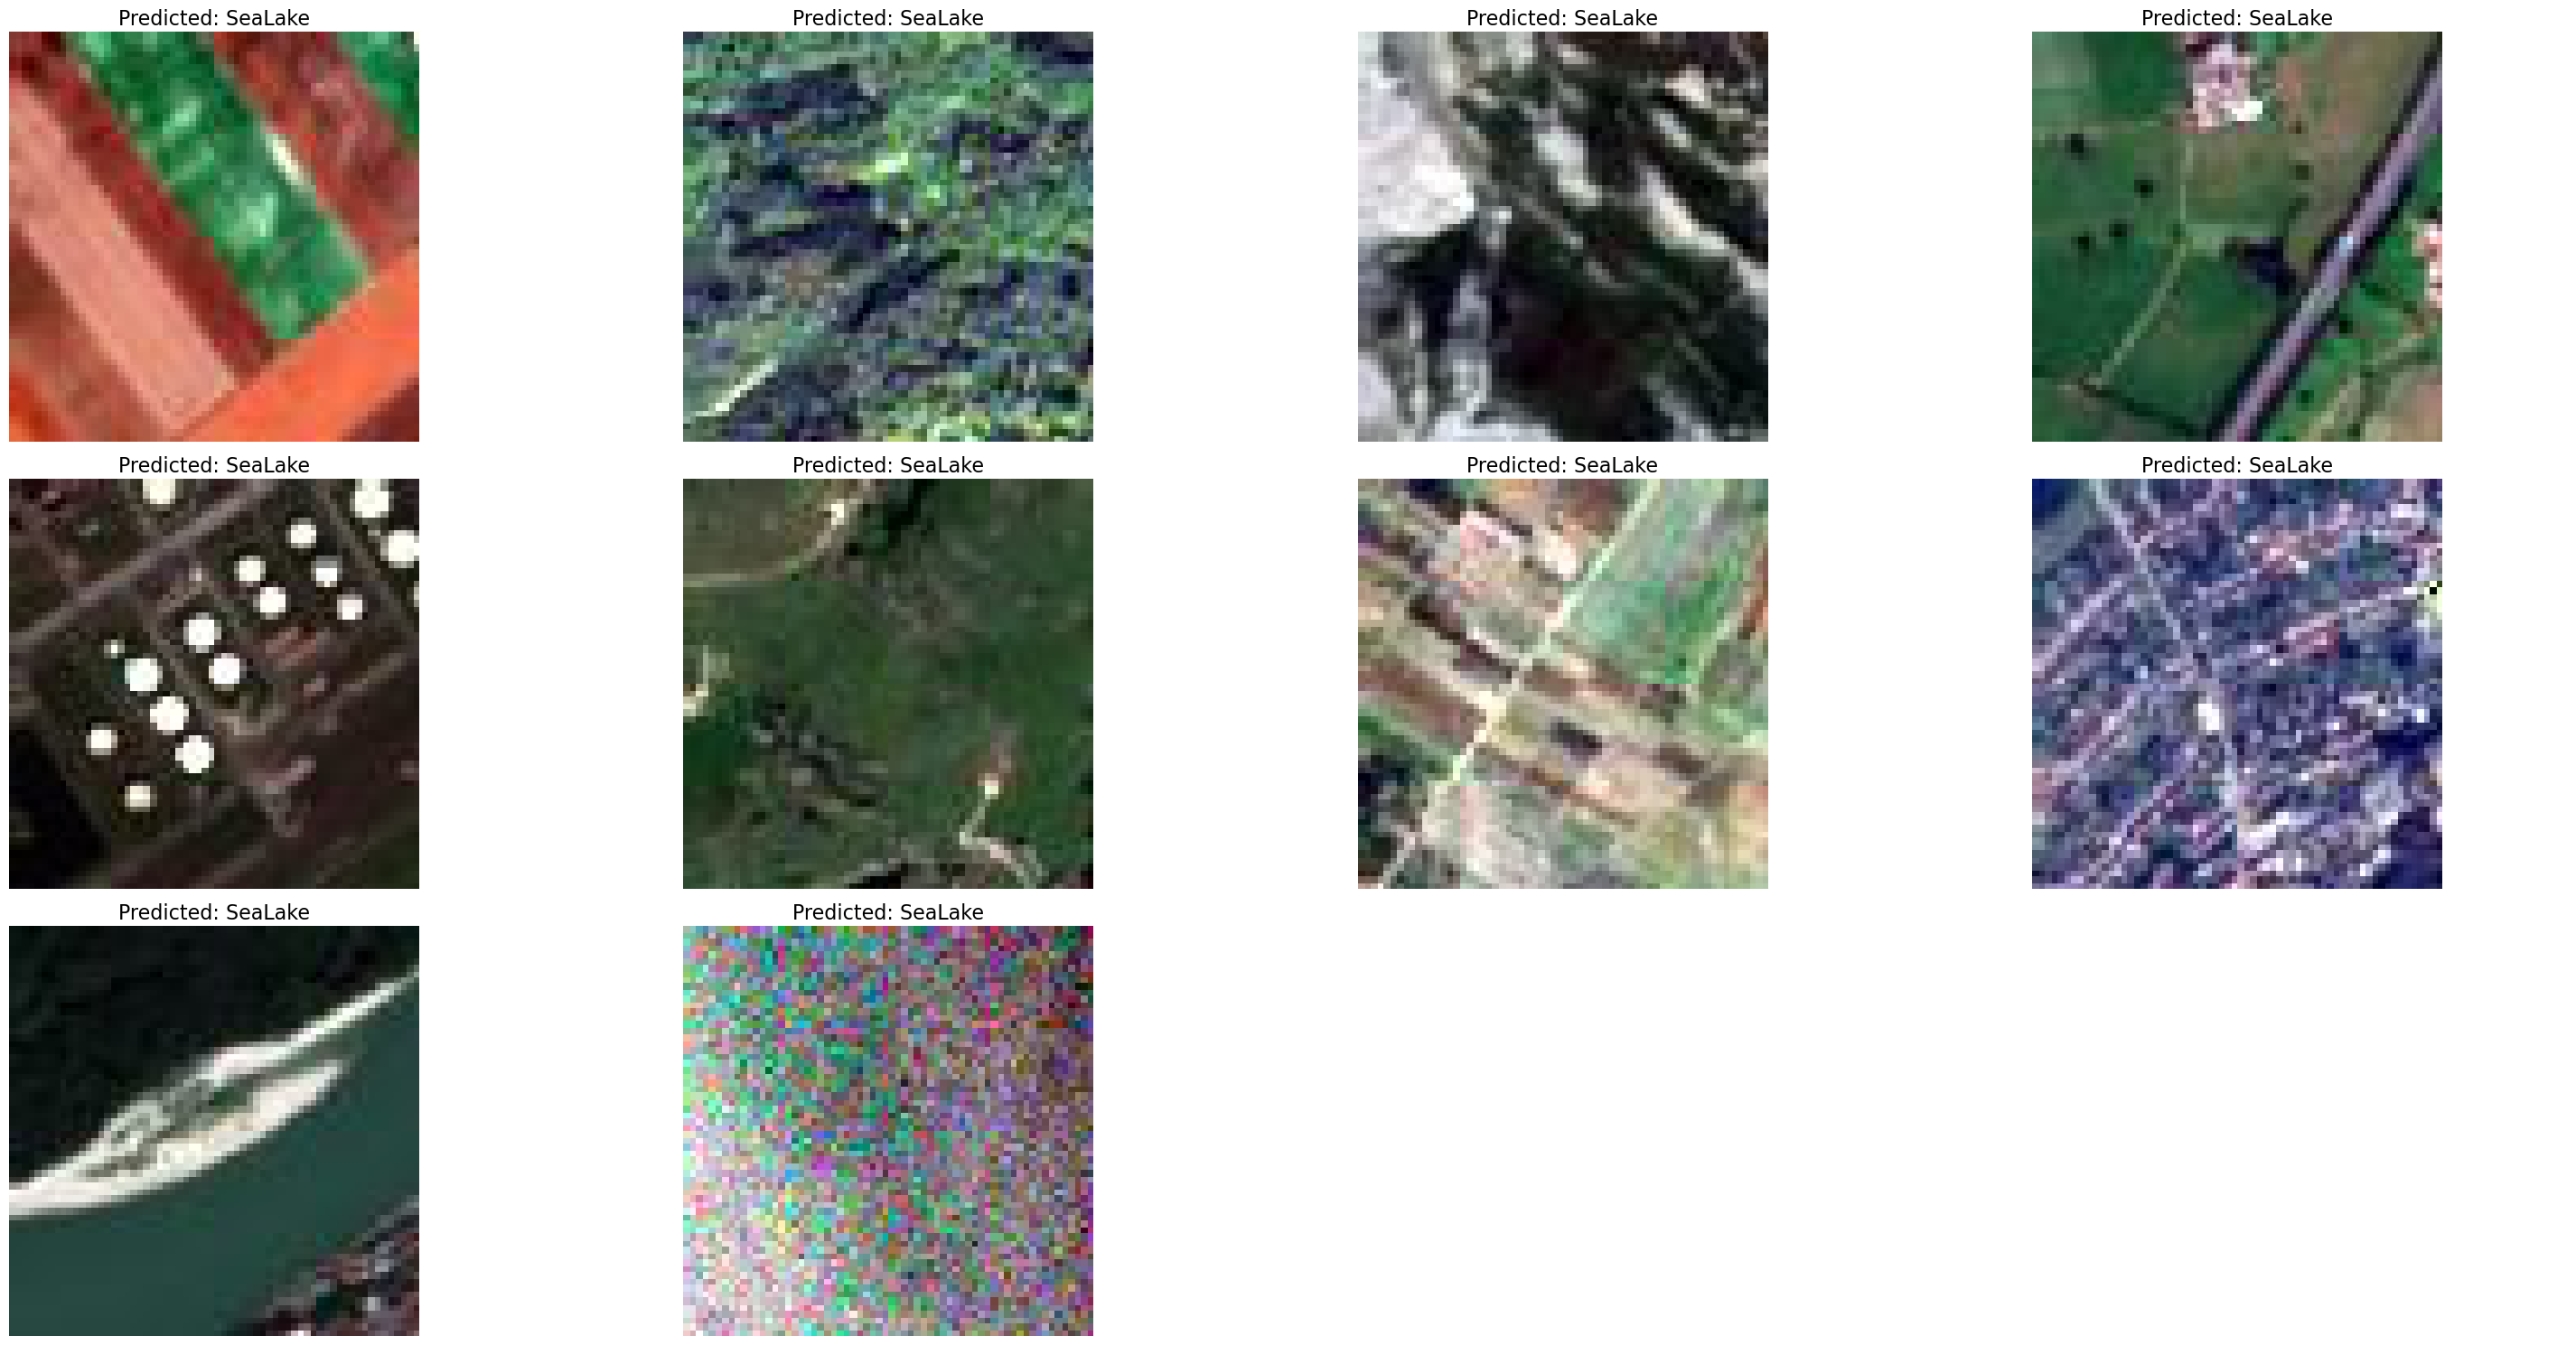

In [49]:
# Function to plot images with labels
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    ims = np.array(ims)
    # Convert to uint8 type for image display
    ims = ims.astype(np.uint8)  # Ensure uint8 for proper display
    # Ensure the images have the correct shape for display
    if ims.shape[-1] != 3:
        ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear', cmap=None)  # Ensure cmap=None
        else:
            ax.axis('Off')
    plt.tight_layout()
    plt.show()

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # target size 64x64 for VGG16
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor, img

# Randomly select one image from each category and predict its class
selected_images = []
titles = []
for category in categories:
    category_path = os.path.join(test_path, category)
    image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_name)
    
    print(f"Selected image path: {image_path}")  # Print the path of the selected image
    
    img_tensor, img = load_and_preprocess_image(image_path)
    # Convert img to array and denormalize for display
    selected_images.append((image.img_to_array(img)))  # Append image in [0, 255] range
    
    # Predict the class
    predictions = model.predict(img_tensor)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    titles.append(f"Predicted: {categories[predicted_class_index]}")

# Display all selected images with predictions
plots(selected_images, rows=len(categories)//4 + 1, titles=titles)

In [54]:
# Ensure the model is built by running it on some input data
_ = model.predict(np.zeros((1, 224, 224, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


In [56]:
layer_indices = [3, 39, 80, 142]  # Example layer indices to extract (adjust as needed)
layer_outputs = [resnet50_model.layers[i].output for i in layer_indices]

In [57]:
activation_model = models.Model(inputs=resnet50_model.input, outputs=layer_outputs)

In [59]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


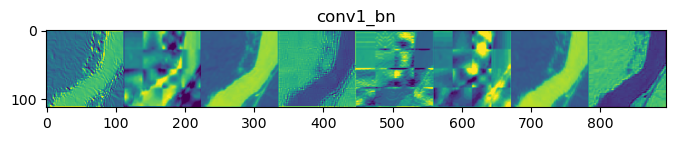

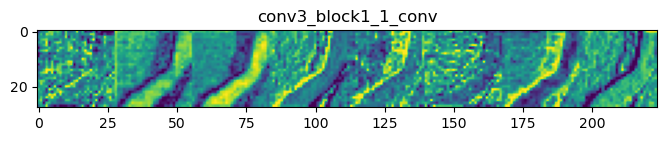

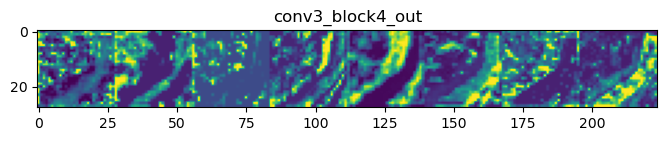

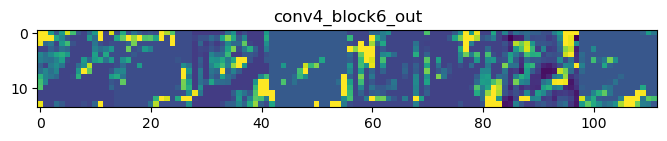

In [60]:
layer_names = [resnet50_model.layers[i].name for i in layer_indices]  # Get layer names for plotting

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of features in the feature map
    size = layer_activation.shape[1]  # Size of the feature map

    # Number of columns in the display grid
    n_cols = 8  # You can adjust this based on the number of feature maps you want to display per row

    # Size of each image in the grid
    display_grid = np.zeros((size, size * n_cols))

    # Fill the display grid with each feature map
    for col in range(n_cols):
        channel_image = layer_activation[0, :, :, col]  # Post-process each channel
        channel_image -= channel_image.mean()  # Normalize to have zero mean
        channel_image /= channel_image.std() + 1e-5  # Normalize to unit variance
        channel_image *= 64  # Scale to [0, 255]
        channel_image += 128  # Shift to [0, 255]
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[:, col * size : (col + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()
